In [21]:
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow
import itertools as it
import matplotlib.pyplot as plt
import math
import copy
from numba import jit
import warnings
warnings.filterwarnings("ignore")

In [22]:
@jit
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.exp(-np.power((x - mu) / sd, 2) / 2)
@jit
def gaussian_kernel(size, sigma=1):
    
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    
    for i in range(size):
          kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)

    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
 
    kernel_2D *= 1.0 / kernel_2D.sum()
 
    return kernel_2D
@jit
def convolve2D(image, kernel,padding=0, strides=1):
    kernel = np.flipud(np.fliplr(kernel))

    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    if padding!=0: 
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
    else:
        imagePadded = image

    for y in range(imagePadded.shape[1]):
        if y > imagePadded.shape[1] - yKernShape:
            break
        if y % strides == 0:
            for x in range(imagePadded.shape[0]):
                if x > imagePadded.shape[0] - xKernShape:
                    break
                try:
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

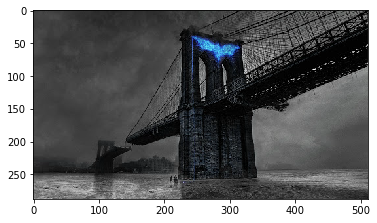

In [55]:
# params
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from functools import cmp_to_key
import logging
k_size=21
imgname = "./images/unnamed.jpg"
# imgname = "/content/Screenshot from 2021-11-19 20-32-10.png"
org_img = cv2.imread(imgname)

plt.imshow(org_img)
org_img = resize(org_img, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
img = cv2.cvtColor(org_img, cv2.COLOR_BGR2GRAY)
# img = resize(img, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
next_img = copy.deepcopy(img)
s = 2
k = math.pow(2,1/s)
# sigma = math.sqrt(2)/2
sigma = 1.61

featurex,featurey = [],[]
feature_len_per_octave = []
keypoints = []
Gaussian_images = []
allkeypoints = []

In [56]:
@jit
def localizeExtremum(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
   
    image_shape = dog_images_in_octave[0].shape
    extremum_is_outside_image = False
    for attempt_index in range(num_attempts_until_convergence):
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
       
        hessian = Hessian_fun(pixel_cube)
        gradient = gradient_fun(pixel_cube)
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
#         print("outside")
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
#         print("not converge")
        return None
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    val=abs(functionValueAtUpdatedExtremum)
    if val * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = val
            return [keypoint, image_index]
    return None
@jit
def gradient_fun(pixel_array):
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return array([dx, dy, ds])

@jit
def Hessian_fun(pixel_array):
    center_pixel_value = pixel_array[1, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
   
    return array([[dxx, dxy, dxs], [dxy, dyy, dys],[dxs, dys, dss]])

In [57]:
@jit
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
           
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < 1e-7:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations


In [58]:
@jit
def Difference_of_Gaussian(images):
  out = []
  for i in range(1,len(images)):
    out.append(images[i]-images[i-1])
  return out

@jit
def get_extrema_features(sigma,octave):
  global s,k,k_size,next_img
  count=0
  imgs = []
  for i in range(s+3):
    g = gaussian_kernel(k_size,sigma)
    out = convolve2D(next_img,g,(k_size-1)//2)
    imgs.append(out)
    sigma= sigma*k
  Gaussian_images.append(imgs)
  out = Difference_of_Gaussian(imgs)
  for cnt in range(1,len(out)-1):
    for i in range(1,out[cnt].shape[0]-1):
      for j in range(1,out[cnt].shape[1]-1):
        curr = out[cnt][i][j]
        no_maxima = False
        no_minima = False
        for i_ in range(-1,2):
          if no_maxima:
            break
          for j_ in range(-1,2):
            if(out[cnt+1][i+i_][j+j_] > curr or out[cnt-1][i+i_][j+j_] > curr or out[cnt][i+i_][j+j_] > curr):
              no_maxima = True
              break
        for i_ in range(-1,2):
          if no_minima:
            break
          for j_ in range(-1,2):
            if(out[cnt+1][i+i_][j+j_] < curr or out[cnt-1][i+i_][j+j_] < curr or out[cnt][i+i_][j+j_] < curr):
              no_minima = True
              break
        extrema = (not no_maxima) ^ (not no_minima)  
        if extrema :
          local_result=localizeExtremum(i,j,cnt,octave-1,2,out,sigma,0.04,0,10,5)
          if local_result is not None:
            keypoints.append({
                'keypoint':local_result[0],
                'octave_no':octave,
                'octave_index':cnt,
            })
            keypoints_with_orientation = computeKeypointsWithOrientations(local_result[0],octave,imgs[local_result[1]])
  
            for kp in keypoints_with_orientation:
              allkeypoints.append({
                  'keypoint':kp,
                  'octave_no':octave,
                  'octave_index':cnt,
                  })
  
  feature_len_per_octave.append(len(featurex))
  return imgs[s],out

def scale_space_extrema(octave):
  global next_img,sigma
  curr_img,out = get_extrema_features(int(math.pow(2,octave-1))*sigma,octave)
  next_img = np.empty((next_img.shape[0]//2,next_img.shape[1]//2))
  next_img = curr_img[::2,::2]

for i in range(2):
  scale_space_extrema(i+1)

In [59]:
featurex = []
featurey = []
for kp in keypoints:
    featurex.append(kp['keypoint'].pt[0])
    featurey.append(kp['keypoint'].pt[1])

In [60]:
fx = copy.deepcopy(np.array(featurex))
fy = copy.deepcopy(np.array(featurey))

In [61]:
print(fx.shape,fy.shape)

(417,) (417,)


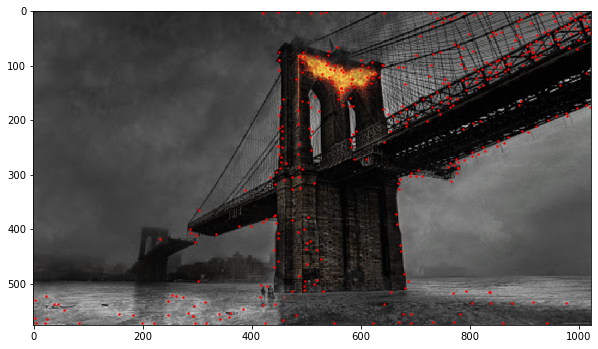

In [62]:
# feature_len_per_octave = feature_len_per_octave -np.hstack((np.array([0]),feature_len_per_octave [:-1]))
feature_img = copy.deepcopy(org_img[:,:,::-1])
plt.figure(figsize=(10,15))
plt.imshow(feature_img)
plt.scatter(fx,fy,c="r",s=2)

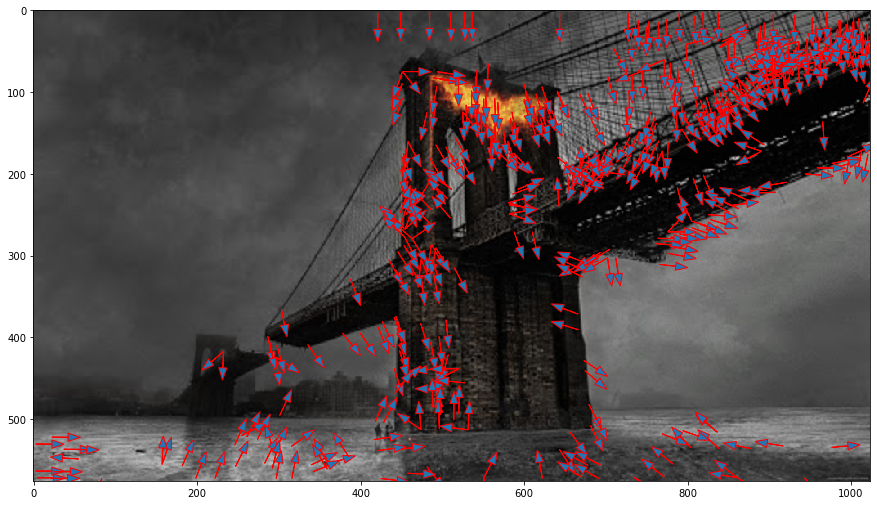

In [63]:
plt.figure(figsize=(15,20))
plt.imshow(org_img[:,:,::-1])

for kp in allkeypoints:
  px = kp['keypoint'].pt[0]
  py = kp['keypoint'].pt[1]
  dx = 20*math.cos(math.pi*kp['keypoint'].angle/180)
  dy = 20*math.sin(math.pi*kp['keypoint'].angle/180)
  plt.arrow(px,py,dx,dy,ec="red", head_width = 10,
          width = 0.05)

plt.show()


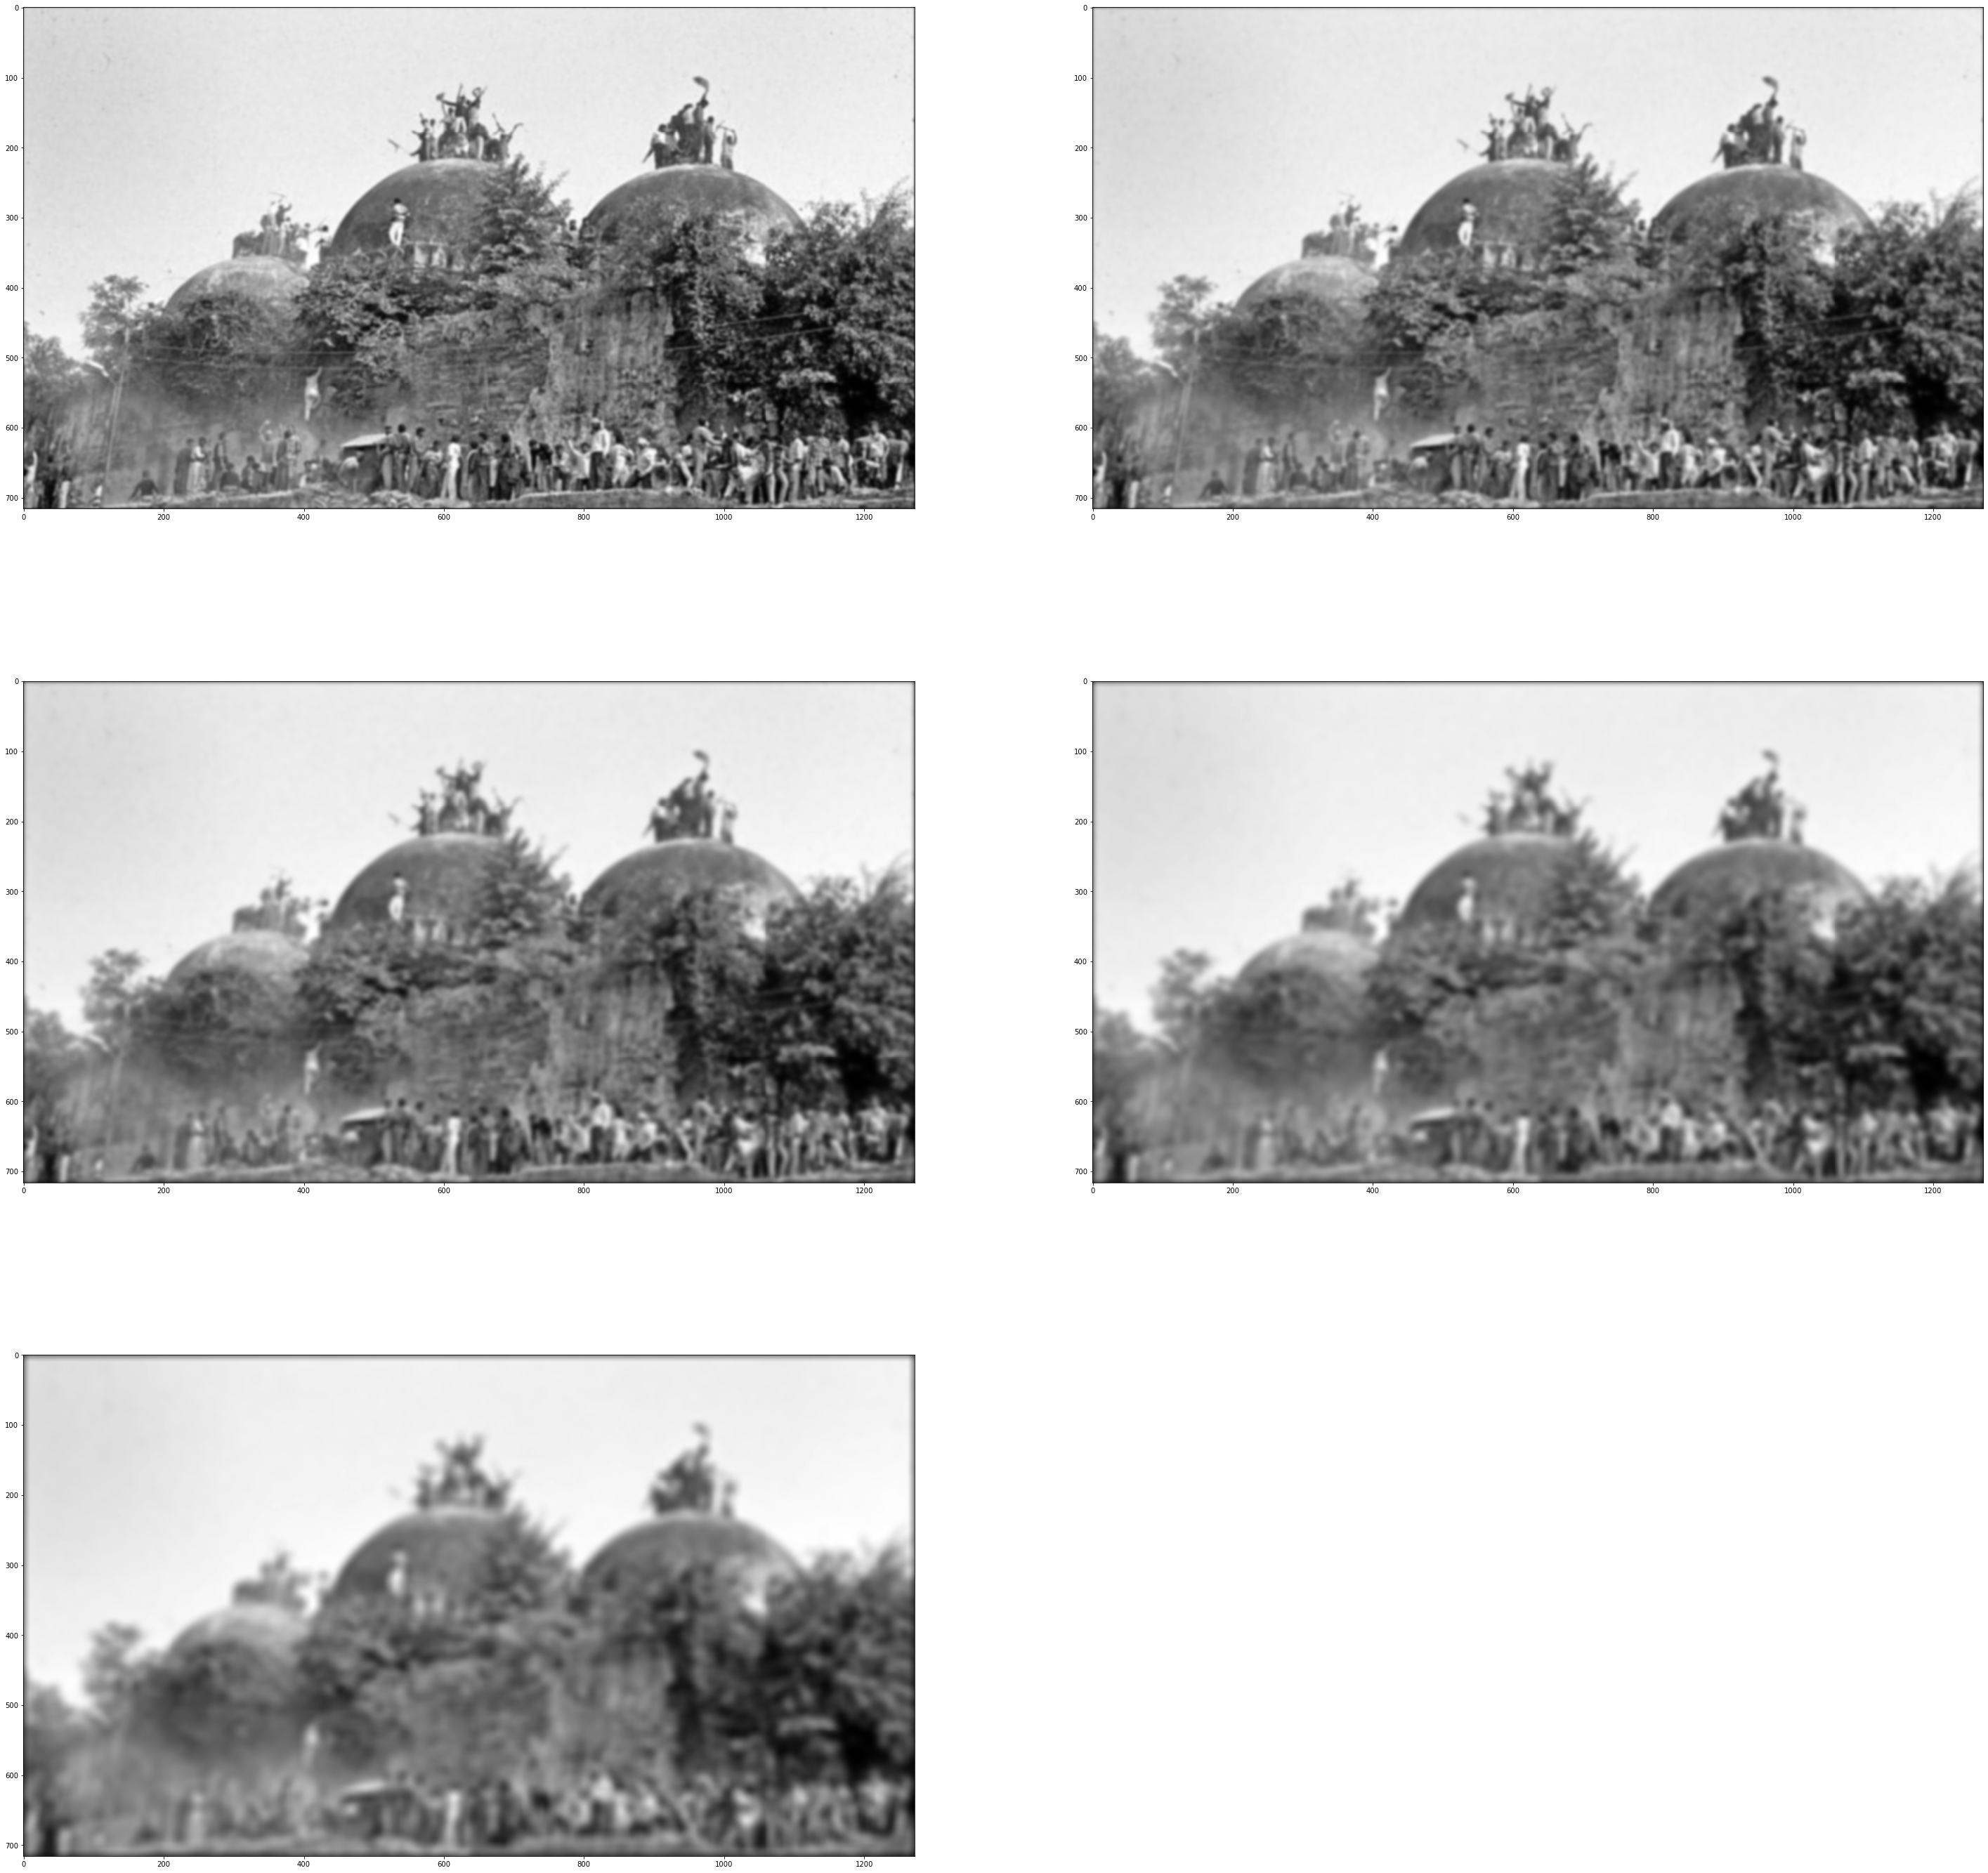

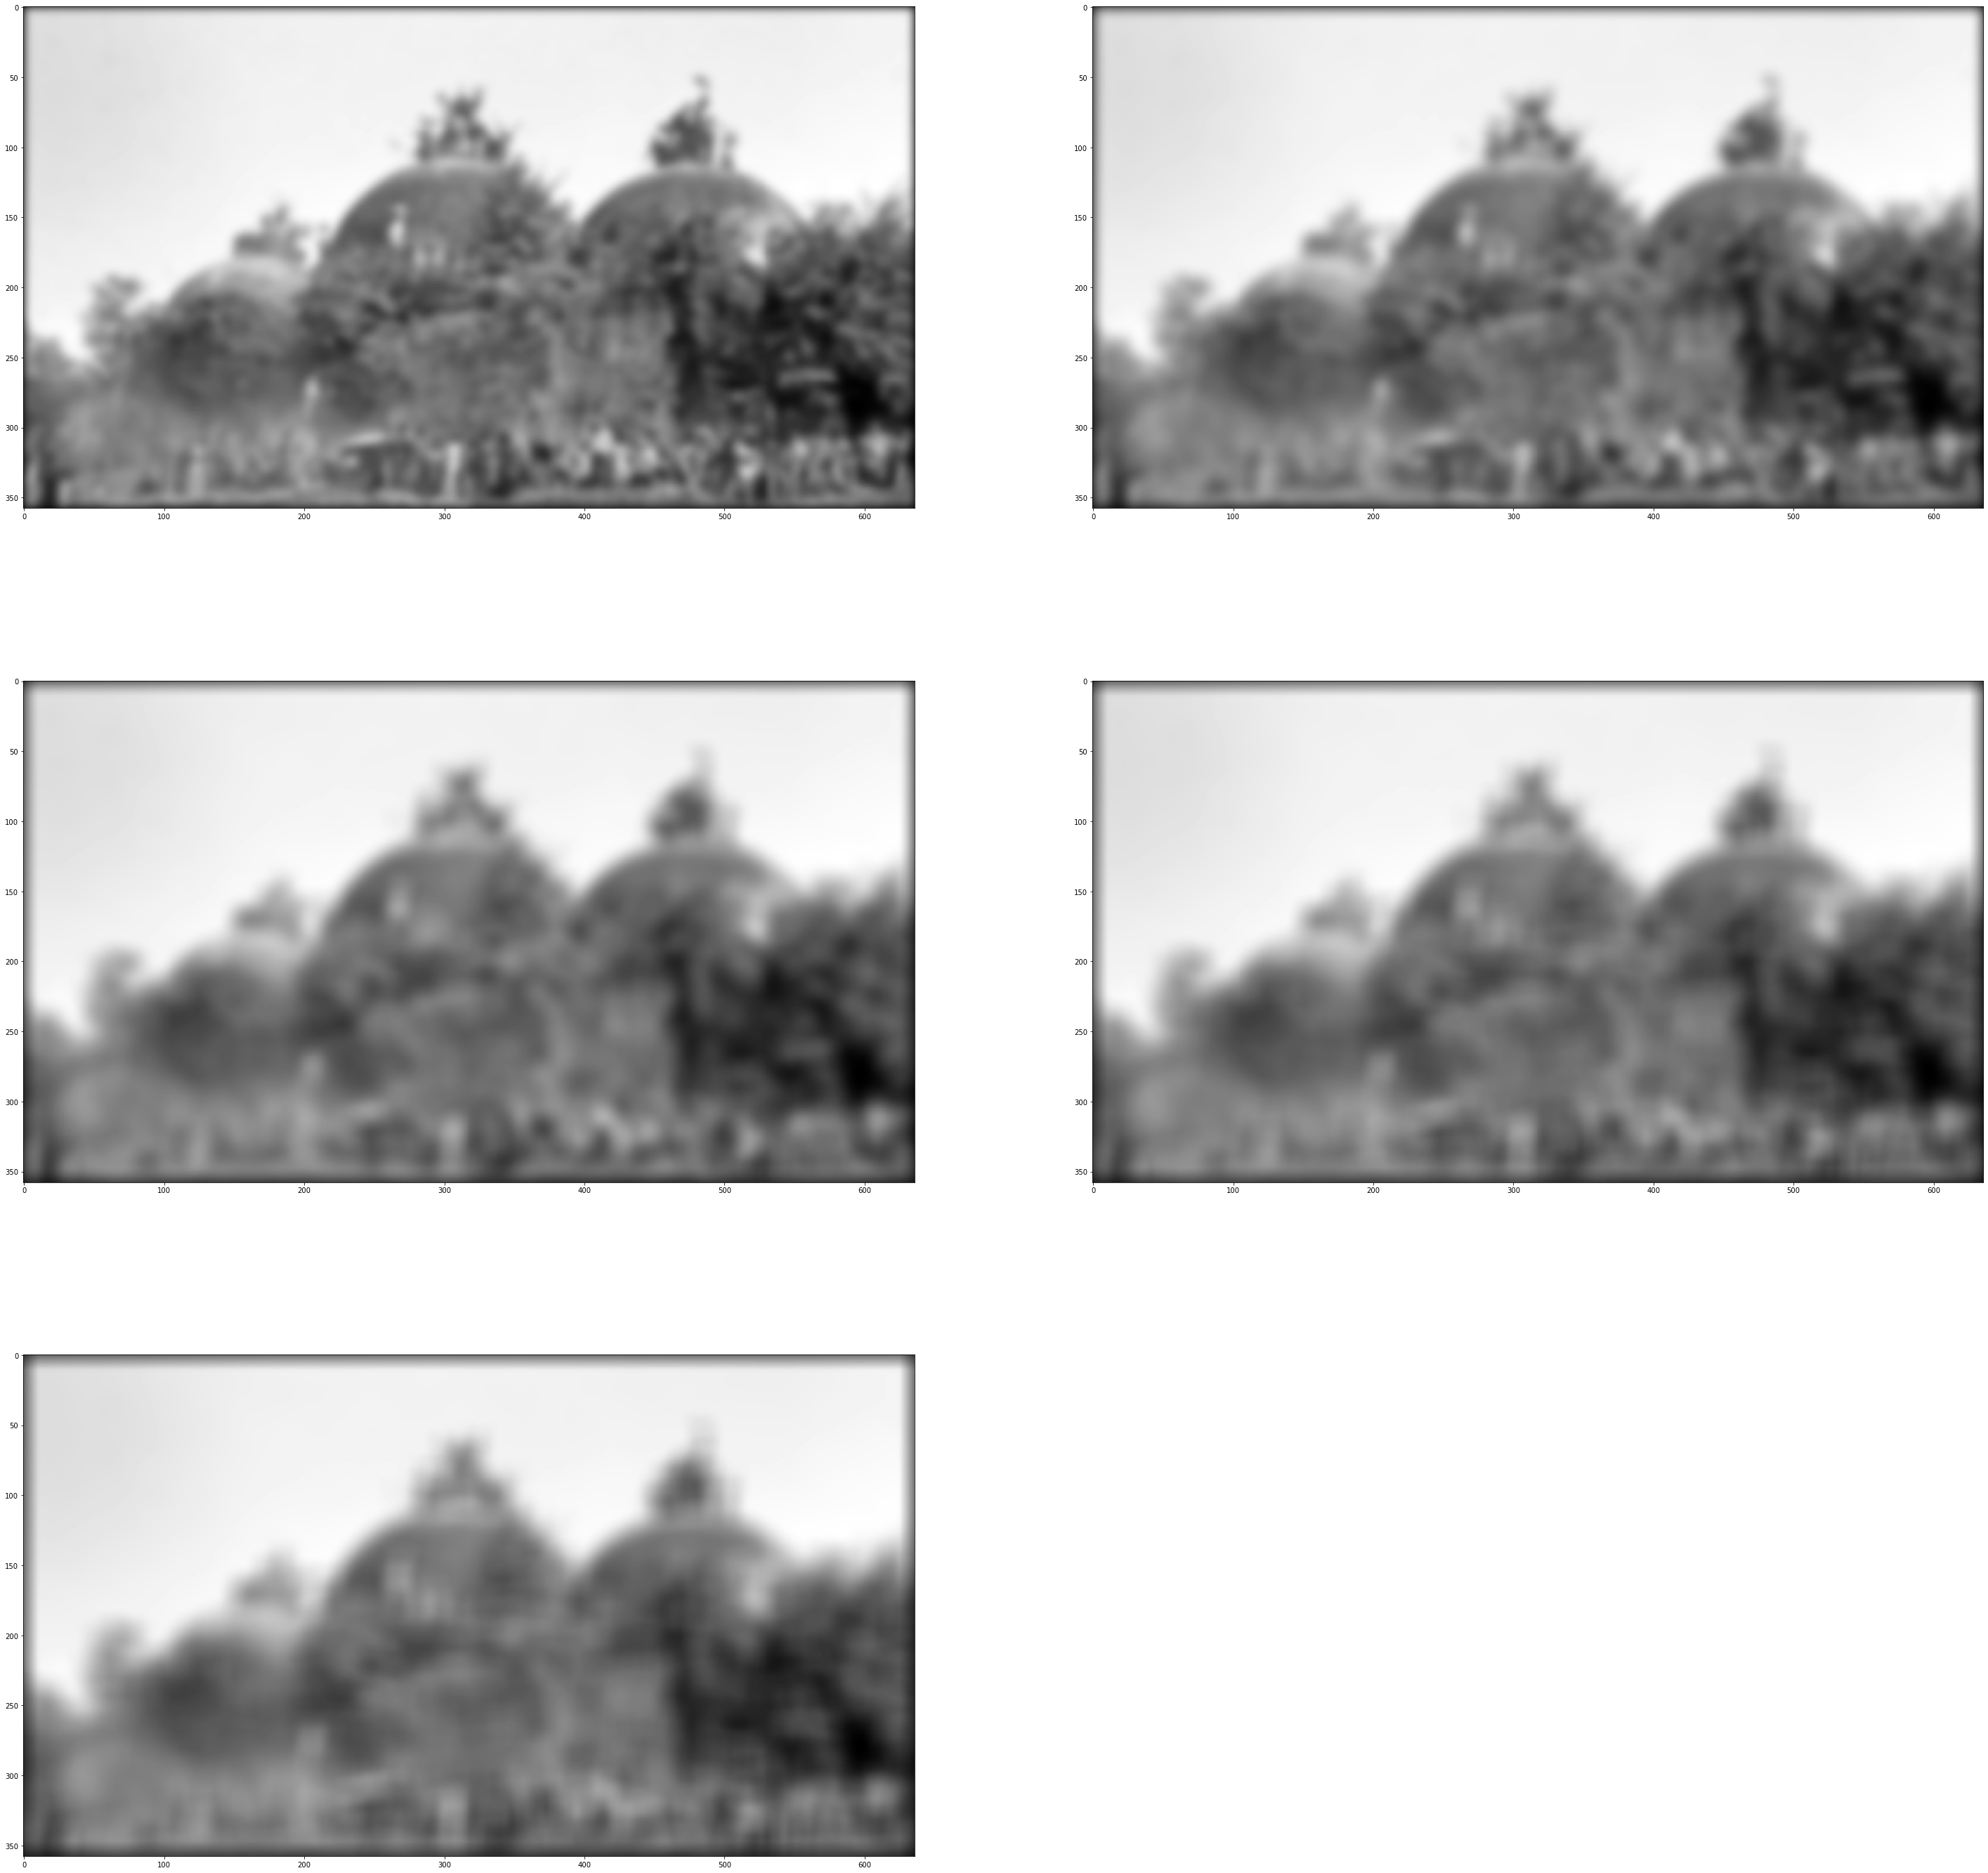

In [54]:
%matplotlib tk
for i_,g in enumerate(Gaussian_images):
    plt.figure(figsize=(50,50))
    for j_,i in enumerate(g):
        plt.subplot(3,2,j_+1)
        plt.imshow(i,cmap="gray")
    plt.show()


In [24]:
@jit
def generateDescriptors(keypoints, gaussian_images, window_width=16, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    descriptors = []

    for kp in keypoints:
        octave = kp['octave_no']
        layer = kp['octave_index']
        kp = kp['keypoint'] 
        scale = 1
        gaussian_image = gaussian_images[octave][layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(kp.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - kp.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   

        hist_width = scale_multiplier * 0.5 * scale * kp.size
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        histogram_tensor = histogram_tensor[1:-1,1:-1,:]
        descriptor_mat = np.empty((4,4,8))
        for i_ in range(4):
          for j_ in range(4):
            descriptor_mat[i_][j_] = np.sum(histogram_tensor[4*i_:4*i_+4][4*j_:4*j_+4],axis = (0,1))
        
        descriptor_vector = descriptor_mat.flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), 1e-7)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')

In [25]:
Gaussian_images = np.array(Gaussian_images)
# print(Gaussian_images.shape)
descriptors = generateDescriptors(allkeypoints[:4],Gaussian_images,window_width=16)

In [29]:
print(descriptors)

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.  10.   5.   2.   2.  11.   8. 115.  13.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0. 163.  69.  19.  28. 163. 149.
  145. 117.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 163. 101.
   26.  90. 163. 163. 163.  85.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [157. 110. 157.  81.  23.  98. 157. 122.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0. 157. 107. 157.  60.  24.  56. 157. 157.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   8.  27.